<a href="https://colab.research.google.com/github/SajjadMzf/VAE/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Import Packages

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Lambda
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.datasets import mnist
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

1. Preparing Data

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, [-1, 784])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, 784])
x_test = x_test.astype('float32') / 255

2. Define The Model

In [20]:

batch_size = 100
epochs = 10

def reparam_trick(args):
  mu, log_sigma = args
  eps = K.random_normal(shape=(100,2))
  return mu + K.exp(log_sigma * 0.5)*eps

def vae_loss(x, x_hat, mu_z, log_sigma_z):
  reconst_loss = binary_crossentropy(x, x_hat) * 784
  kl_loss = 1 + log_sigma_z - K.square(mu_z) - K.exp(log_sigma_z)
  kl_loss *= -0.5
  kl_loss = K.sum(kl_loss, axis = -1)
  return K.mean(reconst_loss + kl_loss)

inputs = Input(shape=(784,), name='in')
enc_h = Dense(128, activation='relu')(inputs)
mu_z = Dense(2)(enc_h)
log_sigma_z = Dense(2)(enc_h)  
z = Lambda(reparam_trick, output_shape=(2,))([mu_z, log_sigma_z])
encoder = Model(inputs, [mu_z, log_sigma_z, z], name='enc')
encoder.summary()

z_in = Input(shape=(2,),name='z_in')
dec_h = Dense(128, activation='relu')(z_in)
dec_out = Dense(784, activation='sigmoid')(dec_h)

decoder = Model(z_in, dec_out, name='dec')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
loss = vae_loss(inputs,outputs,mu_z, log_sigma_z)

vae = Model(inputs, outputs)
vae.add_loss(loss)
vae.compile(optimizer='adam')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 784)          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 128)          100480      in[0][0]                         
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 2)            258         dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 2)            258         dense_24[0][0]                   
__________________________________________________________________________________________________
lambda_6 (

3. Training The Model

In [21]:
vae.fit(x_train, epochs=epochs, batch_size = batch_size)

Epoch 1/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.3128
Epoch 2/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2639
Epoch 3/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.2632
Epoch 4/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2631
Epoch 5/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630
Epoch 6/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2630
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630
Epoch 8/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630
Epoch 9/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.2630
Epoch 10/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.2630


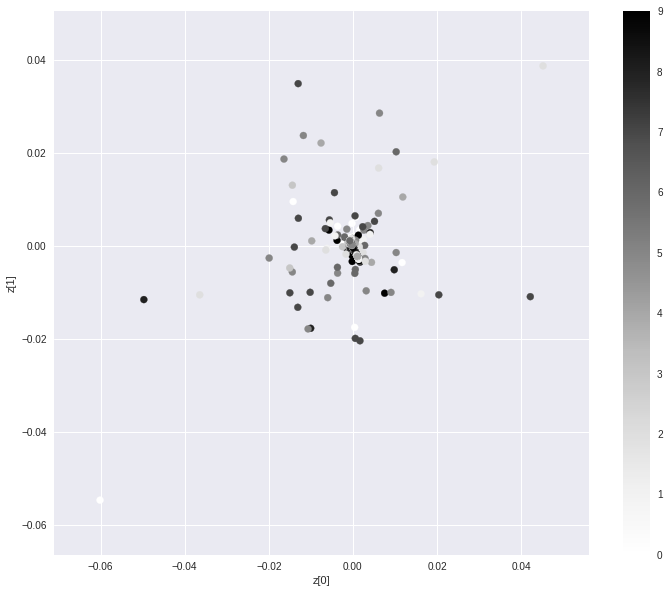

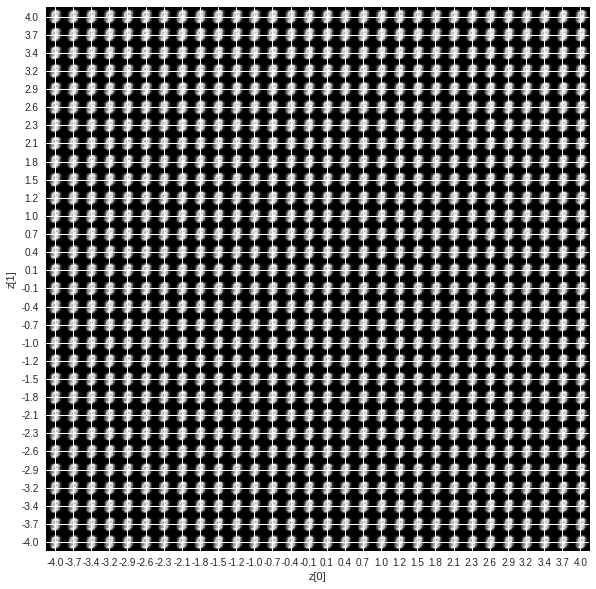

In [22]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

plot_results((encoder, decoder),(x_test, y_test),100,'vae')